In [1]:
%load_ext pycodestyle_magic
%flake8_on

# Objectifs du projet

Nous cherchons à déterminer les bons axes d'analyse des relevés de consommation de la ville de Seattle, afin d'expliciter puis répondre aux objectifs suivants: 
- Tenter de prédire les émissions de CO2 et la consommation totale d’énergie de bâtiments pour lesquels elles n’ont pas encore été mesurées,
- Evaluer l'intérêt de l'ENERGYSTARScore pour la prédiction d'émissions,
- L'objectif à l'horizon 2050 est la neutralité carbone et à ce titre la priorité est donnée aux émissions de CO2 des bâtiments non destinées à l'habitation.

Nous pourrons donc identifier :<br/>
Notebook 1 - Explore Results :<br/>
- les features de résultats (outputs) les plus appropriés,
- les features de profil (inputs) additionnels dérivés des features de résultats sans aller jusqu'à la fuite de données  (exploitation détournée d'output en tant qu'input entrainant un surapprentissage).<br/>

Notebook 2 - Explore Profiles :<br/>
- les features de profil (inputs) caractérisants les bâtiments dont on souhaite prédire les niveaux de consommation et d'émission, i.e. tout nouveau bâtiment n'ayant fait l'objet d'aucune campagne de mesure,
- les features de profil (inputs) additionnels dérivés des features de profil.<br/>

Notebook 3 - Prepare :<br/>
- les transformations des features permettant d'optimiser les performances,
- la restriction des relevés aux bâtiments "non destinés à l'habitation", ainsi que ceux pour lesquels un relevé existe en 2015 mais pas en 2016 et inversement. <br/>

Puis dans la phase de modélisation, investiguer :<br/>
Notebook 4 - Models :<br/>
- les critères d'évaluation de la performance,
- la revue des modèles et leurs paramètres et hyperparamètres,
- l'évaluation de l'intérêt de la prise en compte de l'ENERGYSTARScore dans la prédiction des émissions,
- l'analyse de l'impact de la prise en compte des inputs features bruts ou additionnels dans cette performance,

Pour cela il faut d'abord fusionner les relevés disponibles.<br/>
C'est l'objet du présent Notebook 0 - Merge.


# Merge

## Comparaison des relevés annuels et concaténation

### Comparaison des features disponibles

In [2]:
# importer les packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# Abstract Syntaxt Tree : décomposition d'un container {'a': 'x', 'b': 'y'}.
from ast import literal_eval
# Pour afficher tout le contenu d'une valeur.
pd.set_option('display.max_colwidth', -1)
# Pour afficher toutes les colonnes
pd.options.display.max_columns = 100
# Pour afficher les graphiques

In [3]:
# créer d'un dataframe pour chaque relevé
dat16 = pd.read_csv('2016-building-energy-benchmarking.csv')
dat15 = pd.read_csv('2015-building-energy-benchmarking.csv')
# lister les features pour chaque relevé
feat16 = dat16.columns
feat15 = dat15.columns
# initialiser les descriptions détaillées et ajout du type et du nb de nan
explore16 = dat16.describe(include='all').T
explore15 = dat15.describe(include='all').T
explore16['dtype'] = dat16.dtypes.T
explore15['dtype'] = dat15.dtypes.T
explore16['NaN_sum'] = dat16.isna().sum().T
explore15['NaN_sum'] = dat15.isna().sum().T
# créer un csv pour l'exploitation externe (ergonomie améliorée)
explore16.to_csv('explore16.csv')
explore15.to_csv('explore15.csv')

In [4]:
# exemples 2015
explore15.sample(3)

,count,unique,top,freq,mean,std,min,25%,50%,75%,max,dtype,NaN_sum
ComplianceStatus,3340,2,Compliant,3337,NaN,NaN,NaN,NaN,NaN,NaN,NaN,object,0
ThirdLargestPropertyUseTypeGFA,560,NaN,NaN,NaN,10755.7,22618.5,0,2385.25,5019.5,10275,303910,float64,2780
PrimaryPropertyType,3340,27,Low-Rise Multifamily,998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,object,0


In [5]:
# exemples 2015
explore16.sample(3)

,count,unique,top,freq,mean,std,min,25%,50%,75%,max,dtype,NaN_sum
Electricity(kBtu),3367,NaN,NaN,NaN,3.70761e+06,1.48507e+07,-115417,639487,1.17758e+06,2.82963e+06,6.57074e+08,float64,9
City,3376,1,Seattle,3376,NaN,NaN,NaN,NaN,NaN,NaN,NaN,object,0
ListOfAllPropertyUseTypes,3367,466,Multifamily Housing,866,NaN,NaN,NaN,NaN,NaN,NaN,NaN,object,9


### Réalignement des features
Via exploitation des fichiers .json et observation des données contenues.


In [6]:
# features présents en 2015 mais pas en 2016 :
print('liste des features 2015 absents du relevé 2016 : \n'
      + str(feat15.difference(feat16)))
# features présents en 2016 mais pas en 2015 :
print('liste des features 2016 absents du relevé 2015 : \n'
      + str(feat16.difference(feat15)))

liste des features 2015 absents du relevé 2016 : 
Index(['2010 Census Tracts', 'City Council Districts', 'Comment',
       'GHGEmissions(MetricTonsCO2e)', 'GHGEmissionsIntensity(kgCO2e/ft2)',
       'Location', 'OtherFuelUse(kBtu)', 'SPD Beats',
       'Seattle Police Department Micro Community Policing Plan Areas',
       'Zip Codes'],
      dtype='object')
liste des features 2016 absents du relevé 2015 : 
Index(['Address', 'City', 'Comments', 'GHGEmissionsIntensity', 'Latitude',
       'Longitude', 'State', 'TotalGHGEmissions', 'ZipCode'],
      dtype='object')


- on compare 2 à 2 les émissions totales et intensité d'émissions dont les libellés sont différents dans les 2 relevés.

In [7]:
# détail pour GHGEmissions(MetricTonsCO2e):
explore15.loc[['GHGEmissions(MetricTonsCO2e)']]

,count,unique,top,freq,mean,std,min,25%,50%,75%,max,dtype,NaN_sum
GHGEmissions(MetricTonsCO2e),3330,NaN,NaN,NaN,110.094,409.45,0,9.265,32.74,88.6425,11824.9,float64,10


In [8]:
# détail pour TotalGHGEmissions
explore16.loc[['TotalGHGEmissions']]

,count,unique,top,freq,mean,std,min,25%,50%,75%,max,dtype,NaN_sum
TotalGHGEmissions,3367,NaN,NaN,NaN,119.724,538.832,-0.8,9.495,33.92,93.94,16871,float64,9


In [9]:
# détail pour GHGEmissionsIntensity(kgCO2e/ft2)
explore15.loc[['GHGEmissionsIntensity(kgCO2e/ft2)']]

,count,unique,top,freq,mean,std,min,25%,50%,75%,max,dtype,NaN_sum
GHGEmissionsIntensity(kgCO2e/ft2),3330,NaN,NaN,NaN,0.985339,1.63717,0,0.08,0.46,1.18,31.38,float64,10


In [10]:
# détail pour GHGEmissionsIntensity
explore16.loc[['GHGEmissionsIntensity']]

,count,unique,top,freq,mean,std,min,25%,50%,75%,max,dtype,NaN_sum
GHGEmissionsIntensity,3367,NaN,NaN,NaN,1.17592,1.82145,-0.02,0.21,0.61,1.37,34.09,float64,9


In [11]:
# combien de Comment 2015
explore15.loc[['Comment'], ['count']]

,count
Comment,13


In [12]:
# combien de Comments 2016
explore16.loc[['Comments'], ['count']]

,count
Comments,0


- après vérification que l'unité est bien la même : il faut aligner 2015 'GHGEmissions(MetricTonsCO2e)', 'GHGEmissionsIntensity(kgCO2e/ft2)' et 2016 'GHGEmissionsIntensity', 'TotalGHGEmissions'.
- le cas de 2015 Comment et 2016 Comments est factultatif puisque 2016 Comments est vide.

In [13]:
# aligner les noms de colonnes GHGEmissions, dont les valeurs sont analogues
dat15.rename(
    columns={'GHGEmissions(MetricTonsCO2e)': 'TotalGHGEmissions',
             'GHGEmissionsIntensity(kgCO2e/ft2)': 'GHGEmissionsIntensity',
             'Comment': 'Comments'},
    inplace=True)

- décomposer le feature Location du relevé 2015 en features 2016 : 'Latitude','Longitude', puis 'Address', 'City',  'State', 'ZipCode'

In [14]:
# composition du feature Location
print(dat15['Location'].sample(1))

266    {'latitude': '47.62320708', 'longitude': '-122.32984117', 'human_address': '{"address": "500 YALE AVE N", "city": "SEATTLE", "state": "WA", "zip": "98109"}'}
Name: Location, dtype: object


- il s'agit d'un container {'a': 'x', 'b': 'y'}

In [15]:
# décomposition en latitude / longitude / human_address
# nb à l'aide de : from ast import literal_eval
dat15['Location'] = dat15['Location'].apply(literal_eval)
dat15['Latitude'] = dat15['Location'].apply(lambda x: x['latitude'])
dat15['Longitude'] = dat15['Location'].apply(lambda x: x['longitude'])
dat15['human_address'] = dat15['Location'].apply(lambda x: x['human_address'])

# décomposition de human_address
dat15['human_address'] = dat15['human_address'].apply(literal_eval)
dat15['Address'] = dat15['human_address'].apply(lambda x: x["address"])
dat15['City'] = dat15['human_address'].apply(lambda x: x["city"])
dat15['State'] = dat15['human_address'].apply(lambda x: x["state"])
dat15['ZipCode'] = dat15['human_address'].apply(lambda x: x["zip"])

# retrait des 2 colonnes devenues inutiles
dat15.drop(['Location', 'human_address'], axis=1, inplace=True)

In [16]:
# liste des features pour chaque relevé
feat16 = dat16.columns
feat15 = dat15.columns
# features présents en 2015 mais pas en 2016 :
print('liste des features 2015 absents du relevé 2016 : \n'
      + str(feat15.difference(feat16)))
# features présents en 2016 mais pas en 2015 :
print('liste des features 2016 absents du relevé 2015 : \n'
      + str(feat16.difference(feat15)))

liste des features 2015 absents du relevé 2016 : 
Index(['2010 Census Tracts', 'City Council Districts', 'OtherFuelUse(kBtu)',
       'SPD Beats',
       'Seattle Police Department Micro Community Policing Plan Areas',
       'Zip Codes'],
      dtype='object')
liste des features 2016 absents du relevé 2015 : 
Index([], dtype='object')


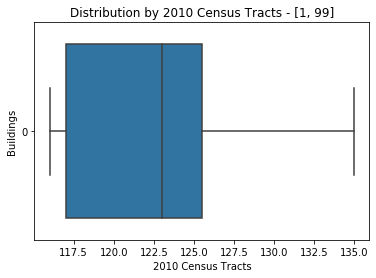

Il y a 6 pourcent(s) des données disponibles, soit 224 données


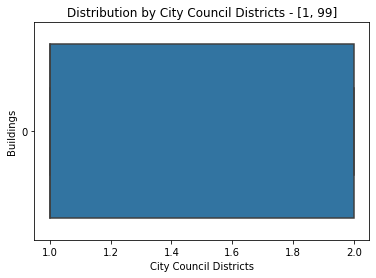

Il y a 6 pourcent(s) des données disponibles, soit 213 données


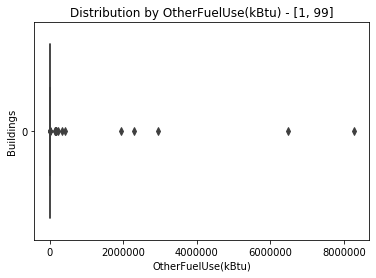

Il y a 99 pourcent(s) des données disponibles, soit 3330 données


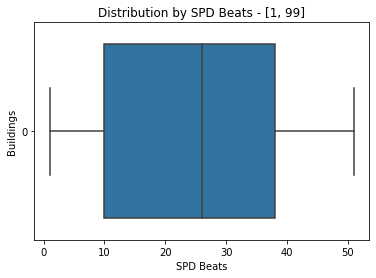

Il y a 99 pourcent(s) des données disponibles, soit 3338 données


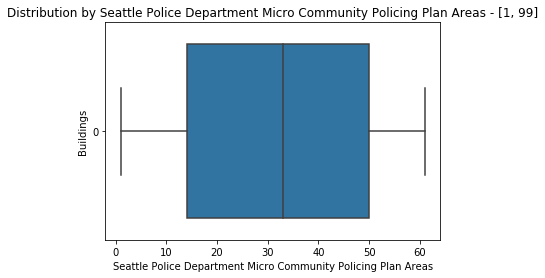

Il y a 99 pourcent(s) des données disponibles, soit 3338 données


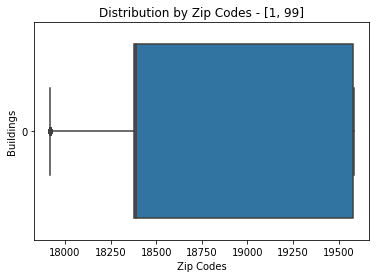

Il y a 100 pourcent(s) des données disponibles, soit 3340 données


In [17]:
# aperçu des valeurs des features présents en 2015 mais pas en 2016
for i in feat15.difference(feat16):
    sns.boxplot(data=dat15[i], whis=[1, 99], orient="h")
    plt.title('Distribution by %s - [1, 99]' % str(i))
    plt.xlabel(i)
    plt.ylabel('Buildings')
    plt.show()
    print('Il y a %d pourcent(s) des données disponibles, soit %d données' % (round(100*((dat15.shape[0]-dat15[i].isna().sum())/dat15.shape[0]), 2), (dat15.shape[0]-dat15[i].isna().sum())))

Ces features présentent l'inconvénient de ne pas être disponibles pour le relevé 2016. Parmi eux : 
- Le feature 'Zip Codes' est désormais redondant du fait de la décomposition de 'Location'.
- Les features '2010 Census Tracts', 'City Council Districts' sont des découpages territoriaux administratifs trop faiblement disponibles et donc non pertinents.
- Les features 'SPD Beats' et 'Seattle Police Department Micro Community Policing Plan Areas' sont des découpages territoriaux relatifs aux forces de police, qu'on ne peut pas considérer comme plus pertinents en première approche par rapport aux autres découpages existants.
- Le feature OtherFuelUse(kBtu) est une des composantes de l'énergie consommmée, très rarement inconnue, mais qu'il serait intéressant de caractériser.

In [18]:
# retirer les colonnes devenues inutiles
dat15.drop(['Zip Codes', '2010 Census Tracts', 'City Council Districts', 'SPD Beats', 'Seattle Police Department Micro Community Policing Plan Areas'], axis=1, inplace=True)

In [19]:
# focus sur les quelques bâtiments ayant un 4ème type d'energie utilisé
unusual = dat15[
                dat15['OtherFuelUse(kBtu)'] != 0
                ].sort_values(by=['OtherFuelUse(kBtu)'])
print('il y a %i bâtiments avec OtherFuelUse' % unusual.shape[0])
print('parmi lesquels il y a %i bâtiments sans valeur pour SiteEUI(kBtu/sf)'
      % unusual['SiteEUI(kBtu/sf)'].isna().sum())

il y a 27 bâtiments avec OtherFuelUse
parmi lesquels il y a 10 bâtiments sans valeur pour SiteEUI(kBtu/sf)


In [20]:
# liste des bâtiments dont la valeur d'energy n'est pas disponible
unexpected = unusual[unusual['SiteEUI(kBtu/sf)'].isna()]
# éviction de ces bâtiments pour analyse la distribution
unusualval = unusual[unusual['SiteEUI(kBtu/sf)'].notna()]

In [21]:
dat15['SiteEUI(kBtu/sf)'].describe()

count    3330.000000
mean     53.626126  
std      53.893311  
min      0.000000   
25%      27.300000  
50%      37.400000  
75%      59.875000  
max      800.600000 
Name: SiteEUI(kBtu/sf), dtype: float64

In [22]:
unusualval['SiteEUI(kBtu/sf)'].describe()

count    17.000000 
mean     84.917647 
std      92.837683 
min      2.300000  
25%      42.000000 
50%      70.400000 
75%      78.000000 
max      420.400000
Name: SiteEUI(kBtu/sf), dtype: float64

Il s'agit donc de 17 bâtiments, dont la valeur d'intensité d'énergie est en moyenne plus élevée plus 10 bâtiments dont la valeur est manquante.

In [23]:
# commentaires dans le cas de valeurs manquantes?
unexpected['Comments'].sample(5)

1838    NaN                                                                                                                                                                                            
1358    Under construction starting 6/2013 (old building demolished) and ending 9/2016. New Building re-opened 9/2016.  Year built changed from 1950 to 2016.                                          
2381    Property now has two buildings: Thornton Creek Elementary School and the Decatur Building. New Thornton Creek Elementary built on Decatur Property and under construction from 6/2013 - 9/2016.
62      Under construction starting 6/2013 (old building demolished) and ending 9/2016. New Building re-opened 9/2016. Year built changed from 1948 to 2016.                                           
719     Construction completed in mid 2015. The building was unoccupied for most of 2015.                                                                                                              


il semble qu'il s'agisse de batiments inoccupés ou en renovation, l'année de construction étant d'ailleurs à modifier selon les commentaires. 

In [24]:
# conserver les 2 listes
unexpected_buildings = unexpected['OSEBuildingID']
unusual_buildings = unusual['OSEBuildingID']
print(unexpected_buildings.size)
print(unusual_buildings.size)

10
27


In [25]:
upunusual = dat16[dat16['OSEBuildingID'].isin(unusual_buildings)]
upunusual.fillna(0)
upunusual['SiteEUI(kBtu/sf)'].describe()

count    24.000000 
mean     74.133333 
std      77.688871 
min      0.000000  
25%      36.675001 
50%      54.850000 
75%      71.299999 
max      389.100006
Name: SiteEUI(kBtu/sf), dtype: float64

In [26]:
upunexpected = dat16[dat16['OSEBuildingID'].isin(unexpected_buildings)]
upunexpected['SiteEUI(kBtu/sf)'].describe()

count    8.000000  
mean     46.075000 
std      42.745149 
min      0.000000  
25%      27.800000 
50%      34.300001 
75%      47.500001 
max      140.199997
Name: SiteEUI(kBtu/sf), dtype: float64

La plupart des données ont fait l'objet d'un relevé en 2016.

In [27]:
# homogénéiser pour OtherFuelUse
dat16['OtherFuelUse(kBtu)'] = 0

- le feature OtherFuelUse(kBtu) pourrait satisfaire au critères de représentativité utile sur 2015 et imputable en valeurs nulle sur le relevé 2016. toutefois cela a peu de chances d'améliorer efficacement l'atteinte de l'objectif compte tenu des efforts que cela demande: à arbitrer lors de l'analyse des features de profils.

In [28]:
# on s'assure que les features sont bien désormais homogènes
feat16 = dat16.columns
feat15 = dat15.columns
# features présents en 2015 mais pas en 2016 :
print('liste des features 2015 absents du relevé 2016 : \n'
      + str(feat15.difference(feat16)))
# features présents en 2016 mais pas en 2015 :
print('liste des features 2016 absents du relevé 2015 : \n'
      + str(feat16.difference(feat15)))

liste des features 2015 absents du relevé 2016 : 
Index([], dtype='object')
liste des features 2016 absents du relevé 2015 : 
Index([], dtype='object')


In [29]:
# cle primaire candidate pour chaque relevé
print('feature-s pouvant servir de clé primaire dans le relevé 2015 : ')
print(str([i for i in feat15 if len(dat15[i].unique()) == len(dat15[i])]))
print('feature-s pouvant servir de clé primaire dans le relevé 2016 : ')
print(str([i for i in feat16 if len(dat16[i].unique()) == len(dat16[i])]))

feature-s pouvant servir de clé primaire dans le relevé 2015 : 
['OSEBuildingID']
feature-s pouvant servir de clé primaire dans le relevé 2016 : 
['OSEBuildingID']


In [30]:
# par quel feature les données sont elles triées?
for i in feat15:
    if dat15[i].is_monotonic_increasing:
        print('pour 2015 le feature %s est trié de façon ascendante' % i)
for i in feat16:
    if dat16[i].is_monotonic_increasing:
        print('pour 2016 le feature %s est trié de façon ascendante' % i)

pour 2015 le feature OSEBuildingID est trié de façon ascendante
pour 2015 le feature DataYear est trié de façon ascendante
pour 2015 le feature City est trié de façon ascendante
pour 2015 le feature State est trié de façon ascendante
pour 2016 le feature DataYear est trié de façon ascendante
pour 2016 le feature City est trié de façon ascendante
pour 2016 le feature State est trié de façon ascendante
pour 2016 le feature OtherFuelUse(kBtu) est trié de façon ascendante


In [31]:
# l'identification du relevé est elle correcte?
print(dat15['DataYear'].unique())
print(dat16['DataYear'].unique())

[2015]
[2016]


## Intersection des relevés

In [32]:
# ré-index par OSEBuilding
dat15e = dat15.set_index('OSEBuildingID').copy()
dat16e = dat16.set_index('OSEBuildingID').copy()

In [33]:
# renommage des features avec suffixe date du relevé
dat15e = dat15e.add_suffix('_15').copy()
dat16e = dat16e.add_suffix('_16').copy()

In [34]:
# on observe l'évolution d'un résultat majeur sur l'intersection des relevés
date = dat15e.join(dat16e, how='inner')
date.name = 'date'

In [35]:
date.shape

(3284, 92)

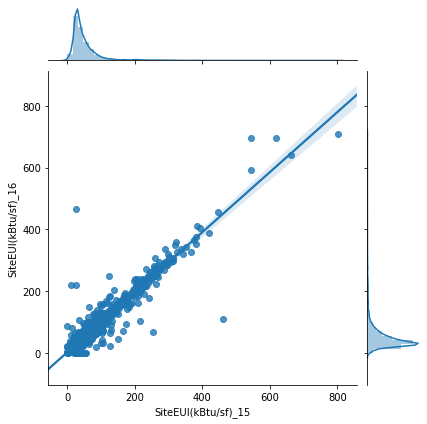

In [36]:
sns.jointplot(date['SiteEUI(kBtu/sf)_15'],
              date['SiteEUI(kBtu/sf)_16'],
              data=date,
              kind='reg')

- on observe une légère variation à la hausse, et quelques valeurs qui ont bcp évolué. 

In [37]:
date['SiteEUI(kBtu/sf)_15'].describe()

count    3275.000000
mean     53.585344  
std      53.225974  
min      0.000000   
25%      27.400000  
50%      37.500000  
75%      59.850000  
max      800.600000 
Name: SiteEUI(kBtu/sf)_15, dtype: float64

In [38]:
date['SiteEUI(kBtu/sf)_16'].describe()

count    3278.000000
mean     54.194814  
std      54.077883  
min      0.000000   
25%      27.799999  
50%      38.500000  
75%      60.275000  
max      707.299988 
Name: SiteEUI(kBtu/sf)_16, dtype: float64

- est-ce le cas pour SiteEnergyUse?

In [39]:
# retirer les valeurs manquantes puis des valeurs négatives ou nulles :
cols = ['SiteEUI(kBtu/sf)_15',
        'SiteEUI(kBtu/sf)_16',
        'SiteEnergyUse(kBtu)_15',
        'SiteEnergyUse(kBtu)_16']
date.dropna(axis=0, how='any', subset=cols, inplace=True)
print(date.shape)
for i in cols:
    print(i)
    date = date[date[i] > 0]
print(date.shape)

(3270, 92)
SiteEUI(kBtu/sf)_15
SiteEUI(kBtu/sf)_16
SiteEnergyUse(kBtu)_15
SiteEnergyUse(kBtu)_16
(3253, 92)


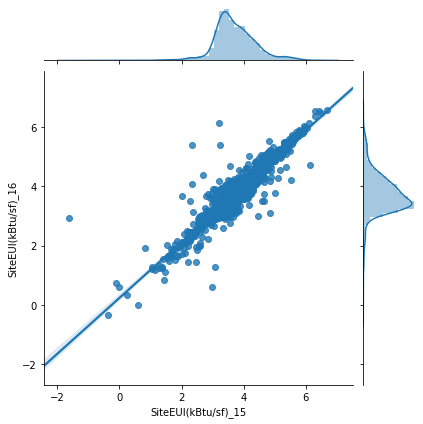

In [40]:
# afficher les intensités d'énergie iso-bâtiment
sns.jointplot(np.log(date['SiteEUI(kBtu/sf)_15']),
              np.log(date['SiteEUI(kBtu/sf)_16']),
              data=date,
              kind='reg')

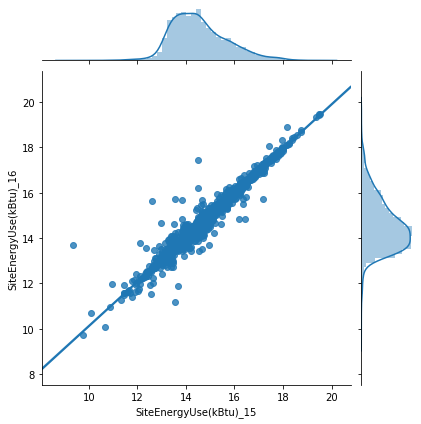

In [41]:
# afficher les totaux d'énergie iso-bâtiment
sns.jointplot(np.log(date['SiteEnergyUse(kBtu)_15']),
              np.log(date['SiteEnergyUse(kBtu)_16']),
              data=date,
              kind='reg')

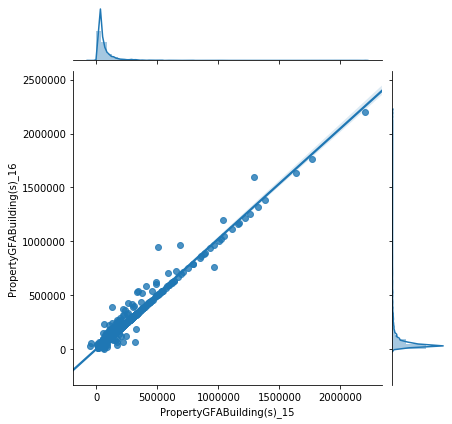

In [42]:
# afficher les surface des bâtiments
sns.jointplot(date['PropertyGFABuilding(s)_15'],
              date['PropertyGFABuilding(s)_16'],
              data=date,
              kind='reg')

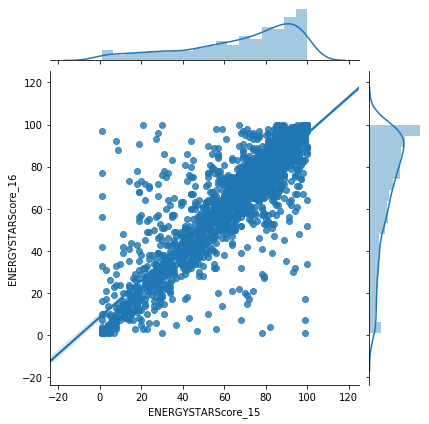

In [43]:
# afficher l'énergie star score
sns.jointplot(date['ENERGYSTARScore_15'],
              date['ENERGYSTARScore_16'],
              data=date,
              kind='reg')

In [44]:
date['ENERGYSTARScore_15'].describe()

count    2503.000000
mean     67.752697  
std      27.293296  
min      1.000000   
25%      51.000000  
50%      76.000000  
75%      90.000000  
max      100.000000 
Name: ENERGYSTARScore_15, dtype: float64

In [45]:
date['ENERGYSTARScore_16'].describe()

count    2461.000000
mean     67.667208  
std      26.720310  
min      1.000000   
25%      53.000000  
50%      75.000000  
75%      89.000000  
max      100.000000 
Name: ENERGYSTARScore_16, dtype: float64

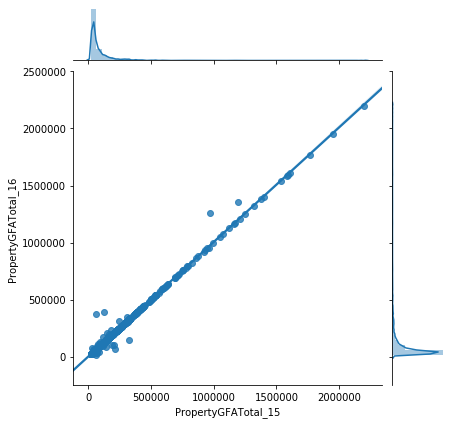

In [46]:
# afficher la surface totale
sns.jointplot(date['PropertyGFATotal_15'],
              date['PropertyGFATotal_16'],
              data=date,
              kind='reg')

In [47]:
date['PropertyGFATotal_15'].describe()

count    3.253000e+03
mean     9.081996e+04
std      1.485423e+05
min      2.000000e+04
25%      2.847000e+04
50%      4.383200e+04
75%      8.877400e+04
max      2.200000e+06
Name: PropertyGFATotal_15, dtype: float64

In [48]:
date['PropertyGFATotal_16'].describe()

count    3.253000e+03
mean     9.106043e+04
std      1.496881e+05
min      1.630000e+04
25%      2.846700e+04
50%      4.379400e+04
75%      8.910300e+04
max      2.200000e+06
Name: PropertyGFATotal_16, dtype: float64

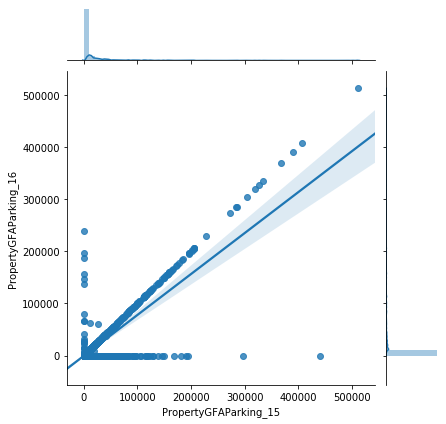

In [49]:
# afficher la surface parking
sns.jointplot(date['PropertyGFAParking_15'],
              date['PropertyGFAParking_16'],
              data=date,
              kind='reg')

In [50]:
date['PropertyGFAParking_15'].describe()

count    3253.000000  
mean     11028.995081 
std      34821.546432 
min     -3.000000     
25%      0.000000     
50%      0.000000     
75%      4414.000000  
max      512608.000000
Name: PropertyGFAParking_15, dtype: float64

In [51]:
date['PropertyGFAParking_16'].describe()

count    3253.000000  
mean     7898.580387  
std      32322.497022 
min      0.000000     
25%      0.000000     
50%      0.000000     
75%      0.000000     
max      512608.000000
Name: PropertyGFAParking_16, dtype: float64

- les surfaces de parking décomptées à part ont globalement diminué en 2016, c'est du à une prise en compte différente plutôt qu'une disparition des surfaces de parking. Soit le parking est pris à part, soit il est intégé dans les usages avec une surface spécifiée.

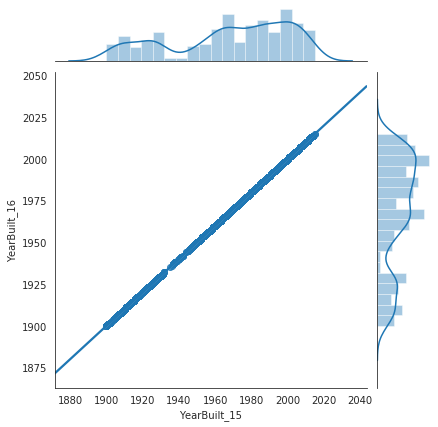

In [52]:
# afficher les années de construction
with sns.axes_style('white'):
    sns.jointplot(date['YearBuilt_15'], date['YearBuilt_16'], data=date, kind='reg')

- on n'a donc pas de recul sur 2 ans de relevés pour identifier des "vraies" rénovations de bâtiments. 

- on décide de conserver dans un premier temps les doublons, au motif que le biais potentiel est moins dommageable que de réduire l'espace des données valides.

## Concaténation des relevés pour analyse


In [53]:
# concaténer les relevés
dat = pd.concat([dat15, dat16], sort=False).reset_index(drop=True)
print('Nb de buildings après concaténation : ' + str(dat.shape[0]))

Nb de buildings après concaténation : 6716


In [54]:
dat.tail(5)

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),OtherFuelUse(kBtu),TotalGHGEmissions,GHGEmissionsIntensity,DefaultData,Comments,ComplianceStatus,Outlier,Latitude,Longitude,Address,City,State,ZipCode
6711,50222,2016,Nonresidential COS,Office,Horticulture building,1624049080,2,GREATER DUWAMISH,1990,1.0,1.0,12294,0,12294,Office,Office,12294.0,NaN,NaN,NaN,NaN,NaN,46.0,69.099998,76.699997,161.699997,176.100006,8.497457e+05,9.430032e+05,0.0,153655.0000,5.242709e+05,3254.750244,3.254750e+05,0.0,20.94,1.70,True,NaN,Error - Correct Default Data,NaN,47.5672,-122.312,1600 S Dakota St,Seattle,WA,NaN
6712,50223,2016,Nonresidential COS,Other,International district/Chinatown CC,3558300000,2,DOWNTOWN,2004,1.0,1.0,16000,0,16000,Other - Recreation,Other - Recreation,16000.0,NaN,NaN,NaN,NaN,NaN,NaN,59.400002,65.900002,114.199997,118.900001,9.502762e+05,1.053706e+06,0.0,116221.0000,3.965461e+05,5537.299805,5.537300e+05,0.0,32.17,2.01,False,NaN,Compliant,NaN,47.5962,-122.323,719 8th Ave S,Seattle,WA,NaN
6713,50224,2016,Nonresidential COS,Other,Queen Anne Pool,1794501150,7,MAGNOLIA / QUEEN ANNE,1974,1.0,1.0,13157,0,13157,"Fitness Center/Health Club/Gym, Other - Recreation, Swimming Pool",Other - Recreation,7583.0,Fitness Center/Health Club/Gym,5574.0,Swimming Pool,0.0,NaN,NaN,438.200012,460.100006,744.799988,767.799988,5.765898e+06,6.053764e+06,0.0,525251.6875,1.792159e+06,39737.390630,3.973739e+06,0.0,223.54,16.99,False,NaN,Compliant,NaN,47.6364,-122.358,1920 1st Ave W,Seattle,WA,NaN
6714,50225,2016,Nonresidential COS,Mixed Use Property,South Park Community Center,7883603155,1,GREATER DUWAMISH,1989,1.0,1.0,14101,0,14101,"Fitness Center/Health Club/Gym, Food Service, Office, Other - Recreation, Pre-school/Daycare",Other - Recreation,6601.0,Fitness Center/Health Club/Gym,6501.0,Pre-school/Daycare,484.0,NaN,NaN,51.000000,55.500000,105.300003,110.800003,7.194712e+05,7.828413e+05,0.0,102248.0000,3.488702e+05,3706.010010,3.706010e+05,0.0,22.11,1.57,False,NaN,Compliant,NaN,47.5283,-122.324,8319 8th Ave S,Seattle,WA,NaN
6715,50226,2016,Nonresidential COS,Mixed Use Property,Van Asselt Community Center,7857002030,2,GREATER DUWAMISH,1938,1.0,1.0,18258,0,18258,"Fitness Center/Health Club/Gym, Food Service, Office, Other - Recreation, Pre-school/Daycare",Other - Recreation,8271.0,Fitness Center/Health Club/Gym,8000.0,Pre-school/Daycare,1108.0,NaN,NaN,63.099998,70.900002,115.800003,123.900001,1.152896e+06,1.293722e+06,0.0,126774.3984,4.325542e+05,7203.419922,7.203420e+05,0.0,41.27,2.26,False,NaN,Compliant,NaN,47.5394,-122.295,2820 S Myrtle St,Seattle,WA,NaN


In [55]:
# décompter les doublons d'OSEBuildingID
print('Doublons sur les ID de bâtiments : '
      + str(dat.duplicated(['OSEBuildingID']).sum()))
# nombre de TaxParcelIdentificationNumber modifiés
print('Nb de dates de TaxParcelIdentificationNumber modifiées : '
      + str(dat.duplicated(['OSEBuildingID']).sum()
            - dat.duplicated(['TaxParcelIdentificationNumber',
                              'OSEBuildingID']).sum()))
# doublons sur les relevés, par le TaxParcelIdentificationNumber
print('Doublons sur les relevés par TaxParcelIdentificationNumber : '
      + str(dat.duplicated(['TaxParcelIdentificationNumber']).sum()))
# nb de date de construction modifiées (même TaxParcelIdentificationNumber)
print('Nb de dates de construction modifiées : '
      + str(dat.duplicated(['TaxParcelIdentificationNumber']).sum()
            - dat.duplicated(['TaxParcelIdentificationNumber',
                              'YearBuilt']).sum()))

Doublons sur les ID de bâtiments : 3284
Nb de dates de TaxParcelIdentificationNumber modifiées : 429
Doublons sur les relevés par TaxParcelIdentificationNumber : 2986
Nb de dates de construction modifiées : 69


In [56]:
# isoler les bâtiments non communs aux 2 relevés :
# dans 2015 mais pas 2016 :
common = dat15.merge(dat16, on=['OSEBuildingID'], how='left', indicator=True)
in15not16 = common[common['_merge'] == 'left_only'].copy()
buldings_in15not16 = in15not16['OSEBuildingID']
print('il y a %i buldings_in15not16' % buldings_in15not16.size)
common = dat16.merge(dat15, on=['OSEBuildingID'], how='left', indicator=True)
in16not15 = common[common['_merge'] == 'left_only'].copy()
buldings_in16not15 = in16not15['OSEBuildingID']
print('il y a %i buldings_in16not15' % buldings_in16not15.size)

il y a 56 buldings_in15not16
il y a 92 buldings_in16not15


In [57]:
# conserver les bâtiments en écart dans les relevés, pour réemploi
in15not16 = pd.DataFrame(buldings_in15not16)
in16not15 = pd.DataFrame(buldings_in16not15)

in15not16.to_csv('in15not16.csv')
in16not15.to_csv('in16not15.csv')

- les 56 bâtiments sans relevé pour 2016 sont ceux dont on pourrait tenter de prédire le résultat (modulo leur représentativité, notamment catégorie non résidentielle), dans l'objectif de compléter le relevés 2016.
- les 92 bâtiments sans relevé pour 2015 sont ceux qu'on pourrait exploiter pour la validation finale des modèles de prédiction (modulo leur représentativité, notamment catégorie non résidentielle)

- Il y a donc un dédoublement de relevés pour la majorité des BuilginsID, on pourrait envisager de ne concerver que les données qui diffèrent pour ne pas sur-apprendre de données trop similaires.

In [58]:
# initialiser les descriptions détaillées et ajout du type et du nb de nan
explore = dat.describe(percentiles=[.01, .25, .5, .75, .99], include='all').T
explore['dtype'] = dat.dtypes.T
explore['NaN_sum'] = dat.isna().sum().T
# sortie csv pour l'exploitation externe (ergonomie améliorée)
explore.to_csv('explore.csv')

## Restriction aux données valides

### Données valides au sens métier

Il s'agit de tenir compte des features que nous classons dans le type "Data" : les informations ajoutées au relevés.

- ComplianceStatus <br/>
- DefaultData <br/>
- Outlier <br/>

il faut conserver OSEBuildingID qui peut servir ultérieurement pour éliminer les doublons (avec DataYear : info prise dans les 2 relevés) et pour reprendre par sous-listes présentes uniquement dans l'un ou l'autre des relevés.<br/>

- DataYear <br/>
- OSEBuildingID <br/>


In [59]:
# identifier les cas de compliance
dat['ComplianceStatus'].unique()

array(['Compliant', 'Not Compliant', 'Error - Correct Default Data',
       'Missing Data', 'Non-Compliant'], dtype=object)

Text(0.5, 1.02, 'Compliance')

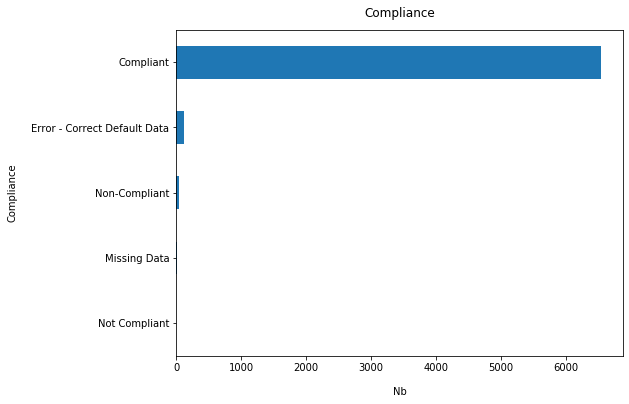

In [60]:
# dénombrer les cas de compliance
dat['ComplianceStatus'].value_counts()[:5].plot(
    kind='barh',
    figsize=(8, 6)).invert_yaxis()
plt.xlabel('Nb', labelpad=14)
plt.ylabel('Compliance', labelpad=14)
plt.title('Compliance', y=1.02)

- on choisit de ne garder que les données Compliant

In [61]:
# retirer les données non compliant
dat = dat[dat['ComplianceStatus'] == 'Compliant'].copy()
dat.shape

(6548, 47)

### cas de DefaultData : <br/>
On apprend sur https://portfoliomanager.energystar.gov, "Default values are derived from the sample population that was used to create each score", ces valeurs par défaut sont donc issues de la totalité des relevés (au moment où on les exploite pour Seattle en 2015 et 2016).  

In [62]:
# identifier les cas de valeur par défaut
dat['DefaultData'].unique()

array(['No', 'Yes', nan, False], dtype=object)

Text(0.5, 1.02, 'DefaultData')

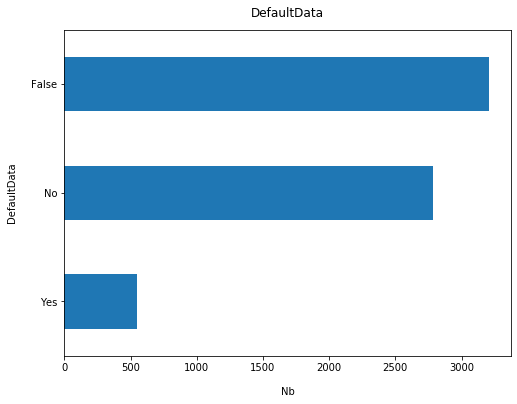

In [63]:
# dénombrer les cas de valeur par défaut
dat['DefaultData'].value_counts()[:5].plot(
    kind='barh',
    figsize=(8, 6)).invert_yaxis()
plt.xlabel('Nb', labelpad=14)
plt.ylabel('DefaultData', labelpad=14)
plt.title('DefaultData', y=1.02)

In [64]:
# projeter le cas de valeurs par défaut
Default = dat[dat['DefaultData'] == 'Yes']
Default.shape

(548, 47)

In [65]:
# profil des valeurs par défaut
Default['SiteEUI(kBtu/sf)'].describe()

count    543.000000
mean     40.919153 
std      25.513538 
min      4.600000  
25%      27.000000 
50%      33.500000 
75%      46.100000 
max      215.800000
Name: SiteEUI(kBtu/sf), dtype: float64

- on choisit de ne conserver que les données ayant DefaultData No ou False, on pourra conserver pour une vérification les données Default.

In [66]:
# transformer en True / False dans les valeurs default
def default(val):
    if (val == "No"):
        return False
    elif (val == "Yes"):
        return True
    else:
        return val


dat['Select_Default'] = dat['DefaultData'].apply(default).astype(str)

In [67]:
# retirer la colonne DefaultData devenue inutile
dat.drop('DefaultData', axis=1, inplace=True)

Text(0.5, 1.02, 'New Default Data')

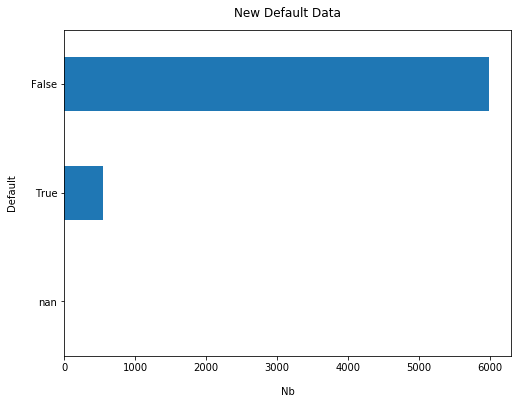

In [68]:
# dénombrer les cas de valeur par défaut
dat['Select_Default'].value_counts().plot(
    kind='barh',
    figsize=(8, 6)).invert_yaxis()
plt.xlabel('Nb', labelpad=14)
plt.ylabel('Default', labelpad=14)
plt.title('New Default Data', y=1.02)

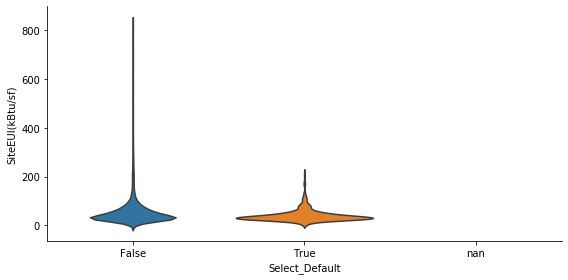

In [69]:
# visualiser la différence de distribution en intensité d'énergie
ax = sns.catplot(x='Select_Default',
                 y='SiteEUI(kBtu/sf)',
                 kind="violin",
                 inner=None,
                 data=dat,
                 height=4,
                 aspect=8/4)
plt.xticks(rotation=0)
plt.show()

- le fait d'avoir des valeurs par défaut dans les relevés a pour effet de retirer des valeurs au delà du dernier quartile, c'est équivalent à un traitement High Outliers.

### "Outliers" au sens des relevés

In [70]:
# identifier les cas d'Outlier
dat['Outlier'].unique()

array([nan, 'High Outlier', 'Low Outlier'], dtype=object)

In [71]:
# rationaliser les valeurs
dat['Select_Outlier'] = dat[['Outlier']].apply(lambda col: col.str.lower())  # devenu inutile suite aux restrictions de validité

Text(0.5, 1.02, 'Outlier')

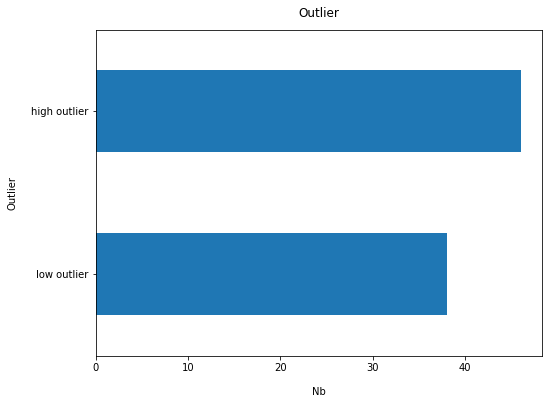

In [72]:
# dénombrer les cas d'outliers
dat['Select_Outlier'].value_counts()[:4].plot(
    kind='barh',
    figsize=(8, 6)).invert_yaxis()
plt.xlabel('Nb', labelpad=14)
plt.ylabel('Outlier', labelpad=14)
plt.title('Outlier', y=1.02)

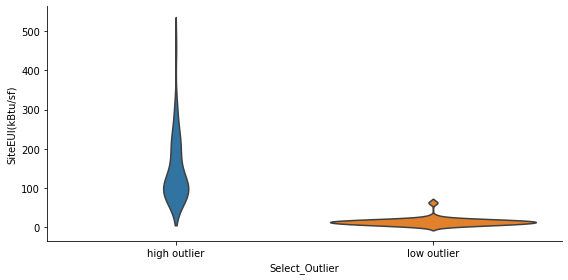

In [73]:
# visualiser la différence de distribution en intensité d'énergie
ax = sns.catplot(x='Select_Outlier',
                 y='SiteEUI(kBtu/sf)',
                 kind="violin",
                 inner=None,
                 data=dat,
                 height=4,
                 aspect=8/4)
plt.xticks(rotation=0)
plt.show()

In [74]:
# isoler les low et high outliers
Lout = dat[dat['Select_Outlier'] == 'low outlier']
Hout = dat[dat['Select_Outlier'] == 'high outlier']

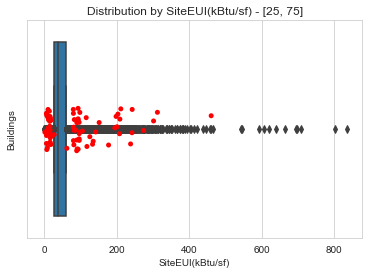

In [75]:
# superposer les outliers dans la distribution de SiteEUI(kBtu/sf)
sns.set_style("whitegrid")
ax = sns.boxplot(x='SiteEUI(kBtu/sf)', data=dat, whis=[25, 75], orient="h")
ax = sns.stripplot(x='SiteEUI(kBtu/sf)', data=Lout, orient='h', color='red')
ax = sns.stripplot(x='SiteEUI(kBtu/sf)', data=Hout, orient='h', color='red')
plt.title('Distribution by SiteEUI(kBtu/sf) - [25, 75]')
plt.xlabel('SiteEUI(kBtu/sf)')
plt.ylabel('Buildings')
plt.show()

- les outliers tels que déclarés dans le relevés sont hors quartile mais pas hors percentile.
- on conserve donc ces items quitte à recalculer plus statistiquement leur valeurs pour garder/retirer les outliers.

- On pourrait également exploiter ce feature pour l'augmenter des outliers détectés au fil des observations. Cela permettrait alors d'observer l'influence de la prise en compte ou retrait des outliers sur la modélisation.

In [76]:
# retirer les valeurs manquantes ou nulles du feature 'SiteEUI(kBtu/sf)'
dat = dat[dat['SiteEUI(kBtu/sf)'] != 0].copy()
dat = dat[~dat['SiteEUI(kBtu/sf)'].isna()].copy()
dat.shape

(6539, 48)

In [77]:
# identifier les valeurs nulles et manquantes pour l'intensité d'énergie 
print('il y a %i valeurs nulles pour SiteEUI(kBtu/sf)'
      % len(dat.index[(dat['SiteEUI(kBtu/sf)'] == 0)]))
print('il y a %i valeurs manquantes pour SiteEUI(kBtu/sf)'
      % dat['SiteEUI(kBtu/sf)'].isna().sum())

il y a 0 valeurs nulles pour SiteEUI(kBtu/sf)
il y a 0 valeurs manquantes pour SiteEUI(kBtu/sf)


1:73: W291 trailing whitespace


In [78]:
# créer un csv pour continuation
dat.to_csv('dat1.csv', index=False)

- on n'a plus de feature susceptible de constituer une clé primaire pour le dataset. 